In [1]:
# Fix convergence of GuSTO
# Create new environment? Yeah I guess we can try
# Plot new environment 
# Run GuSTO with different points, does it converge?
# Plot solution on top of new environment. Does it look good?
# Set up lots of initial and final points, and store resulting data

In [2]:
include("astrobee_se3_script.jl")
using Plots
using JLD2, FileIO

In [3]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true)
    
    Xp,Up = initialize_trajectory(model, N)
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, X_all, U_all
end

solve_gusto (generic function with 2 methods)

In [4]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

In [5]:
function plot_solution(model, X_all)
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot()
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[1,:], X[2,:]; c=:blue)
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius; color=:red, fig=fig)
    end

    return fig
end

plot_solution (generic function with 1 method)

In [6]:
function plot_env_and_trajs(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    if size(X_all,1)>1
        labls[end] = "Solution"
    end
    
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter])
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg = true)
    return fig
end

plot_env_and_trajs (generic function with 2 methods)

In [7]:
function storeInputOutput(x_init, x_final, X_soln, U_soln)
    # X_soln # This is 13x50. I want this to be 1x13*50
    # U_soln # This is 6x 49. I want this to be 1x6*49
    X_row = (X_soln[:]) # 650 elements All at time 1 together (13), then next 13 for time 2, etc, 
    U_row = (U_soln[:]) # 294 elements All at time 1 together (6), then next 6 for time 2, etc.
    train_output = vcat([X_row, U_row]...)' # This is 944 elements
    train_input = vcat([x_init, x_final]...)' # This is 26 elements
    return train_input, train_output
end

storeInputOutput (generic function with 1 method)

# How to recover solutions from training data

In [8]:
function getComponentsFromData(train_input, train_output)
    N = 50 
    x_dim = 13
    u_dim = 6
    x_init = train_input[1:x_dim]
    x_final = train_input[x_dim+1:end]
    X_row = train_output[1:x_dim*N]
    X_soln = reshape(X_row, (x_dim,N))
    U_row = train_output[(1+x_dim*N) : end]
    U_soln = reshape(U_row, (u_dim,N-1))
    return x_init, x_final, X_soln, U_soln
end

getComponentsFromData (generic function with 1 method)

In [9]:
train_input, train_output = storeInputOutput(x_init, x_final, X_soln, U_soln)
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)
@show (x_init == x_init_recov)
@show (x_final == x_final_recov)
@show (X_soln == X_soln_recov)
@show (U_soln == U_soln_recov)

UndefVarError: UndefVarError: x_init not defined

# Simpler case

In [12]:
N = 50
MAX_ITERATIONS_NB = 100

model = AstrobeeSE3()

# Set up environment
model.x_max[1:3] = [10.0; 10.0; 1.0]
model.x_min[1:3] = [0.0; 0.0; 0.0]

obstacles = []
# obs = [[0.0,0.0,0.0], 6.0]
# push!(obstacles, obs)
model.obstacles = obstacles

poly_obstacles = []
obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
push!(poly_obstacles, obs)
obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
push!(poly_obstacles, obs)
model.poly_obstacles = poly_obstacles

model.tf_guess = 110.
model.convergence_threshold = 0.7

model.x_init = [9.0;7.0;0.5;  0;0;0;  0.;0.;0.; 1.;  0;0;0]
model.x_final = [9.0 ;1.0;0.5;  0;0;0;  0.;0.;1.; 0.;  0;0;0]

time_start = time_ns()
isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
gusto_solve_time = (time_ns() - time_start)/10^9
@show gusto_solve_time
@show size(X_all)
@show size(U_all)

gusto_solve_time = 2.242168306
size(X_all) = (6,)
size(U_all) = (6,)


(6,)

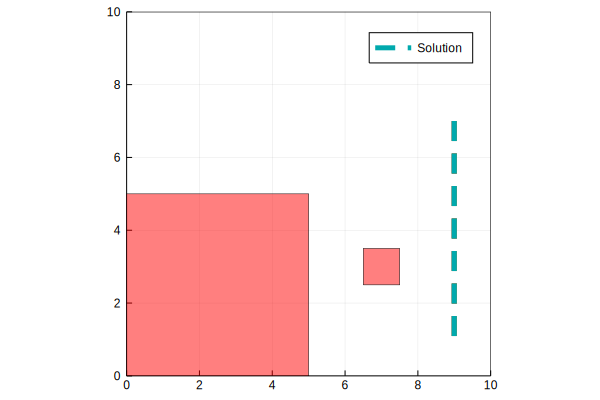

In [13]:
plot_env_and_trajs(model, X_all)

# Testing obstacle function

In [10]:
N = 50
MAX_ITERATIONS_NB = 100

model = AstrobeeSE3()

# Set up environment
model.x_max[1:3] = [10.0; 10.0; 1.0]
model.x_min[1:3] = [0.0; 0.0; 0.0]

obstacles = []
# obs = [[0.0,0.0,0.0], 6.0]
# push!(obstacles, obs)
model.obstacles = obstacles

poly_obstacles = []
obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
push!(poly_obstacles, obs)
obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
push!(poly_obstacles, obs)
model.poly_obstacles = poly_obstacles

model.tf_guess = 110.
model.convergence_threshold = 0.7

model.x_init = [1.0;7.0;0.5;  0;0;0;  0.;0.;0.; 1.;  0;0;0]
model.x_final = [8.0 ;1.0;0.5;  0;0;0;  0.;0.;1.; 0.;  0;0;0]

time_start = time_ns()
isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
gusto_solve_time = (time_ns() - time_start)/10^9
@show gusto_solve_time
@show size(X_all)
@show size(U_all)

UndefVarError: UndefVarError: AstrobeeSE3 not defined

In [35]:
x_init = [7.0;3.0;1.0; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
isInsideObstacle(x_init, model)

true

In [ ]:
# labs = fill("",(size(X_all,1),1))
# labs[end] = "Solution"
plot_env_and_trajs(model, X_all)

# Collecting data

In [ ]:
N = 50
MAX_ITERATIONS_NB = 100

model = AstrobeeSE3()

# Set up environment
model.x_max[1:3] = [10.0; 10.0; 1.0]
model.x_min[1:3] = [0.0; 0.0; 0.0]

obstacles = []
# obs = [[0.0,0.0,0.0], 6.0]
# push!(obstacles, obs)
model.obstacles = obstacles

poly_obstacles = []
obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
push!(poly_obstacles, obs)
obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
push!(poly_obstacles, obs)
model.poly_obstacles = poly_obstacles

model.tf_guess = 110.
model.convergence_threshold = 0.7

x_vals = range(0.5, stop = 4., length = 9)
y_vals = range(5.5, stop = 8.0, length = 9)
# z_vals = range(model.x_min[3], stop = model.x_max[3], length = 10)
z_vals = [0.5]

x_vals_rev = range(5.5, stop = 9.5, length = 9)
y_vals_rev = range(0.5, stop = 5.0, length = 9)
# z_vals_rev = range(model.x_max[3], stop = model.x_min[3], length = 10)
z_vals_rev = [0.5]

problemNumber = 0

train_input_collected = Array{Float64}(undef,0,26)
train_output_collected = Array{Float64}(undef,0,944)

for x_start in x_vals
    for y_start in y_vals
        for z_start in z_vals
            x_init = [x_start;y_start;z_start; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
            if isInsideObstacle(x_init, model)
                continue
            end
            for x_goal in x_vals_rev
                for y_goal in y_vals_rev
                    for z_goal in z_vals_rev
                        x_final = [x_goal;y_goal;z_goal; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
                        if isInsideObstacle(x_final, model)
                            continue
                        end
                        if norm(x_final[1:3] - x_init[1:3])<1.0
                            continue
                        end
                        
                        problemNumber = problemNumber + 1
                        @show problemNumber
                        
                        model.x_init = x_init
                        model.x_final = x_final
                        
                        try
                            isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, false)
                        catch e
                            println("$e")
                        end
                        @show isConverged
                        
                        if isConverged
                            X_soln = X_all[end]
                            U_soln = U_all[end]
                            train_input, train_output = storeInputOutput(x_init, x_final, X_soln, U_soln)                            
                            train_input_collected = vcat(train_input_collected, train_input)
                            train_output_collected = vcat(train_output_collected, train_output)
                            @show size(train_input_collected)
                            @show size(train_output_collected)
                            
                            @save "PolyMore.jld2" train_input_collected train_output_collected
                        end
                    end
                end
            end
        end
    end
end


problemNumber = 1
isConverged = true
size(train_input_collected) = (1, 26)
size(train_output_collected) = (1, 944)
problemNumber = 2
isConverged = 

In [ ]:
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)
plot_env_solution(model, X_soln_recov)